## Bayesian approach to ab testing (CR and CTR)

Here we try to use bayesian approach to compare features in group A (control) versus group B (test).
Posterior distribution for CR and CTR is assumed to be Beta. (It is used because of conjugate prior).

### Settings
These blocks doesn't requier any changes

In [20]:
from db_conn import *
from sql import *
from conf import *
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
import matplotlib.pyplot as plt;
import matplotlib.ticker as mtick;

%pylab inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Sergey's output options
pd.set_option('display.max_rows', 10)
pd.set_option('precision', 3)
pd.set_option('expand_frame_repr', False)

### Obtaining data

In [4]:
hive_cursor = conn_hd()

Connected to Hadoop db.


### Parameters set here

You need to set: 
1. host_group 
2. split_name 
3. split_name2 
4. date_begin 
5. date_end
6. test_value
7. control_value

In [5]:
host_group = 'RU production'

#for cr
country = COUNTRY[host_group]
source = DATA_SOURCE[host_group]
domain = "'" + DOMAIN_NAME[host_group] + "'"
split_name = "'split_lamoda_mobile'" # split_lamoda_mobile, split_lamoda_ranking and split_lamoda_5

#for pp rate
referrer = REFERRER[host_group]
http_referer = HTTP_REFERRER[host_group]
source2 = DATA_SOURCE2[host_group]
split_name2 = "'slm'" #'slm','slr' and 'sl5' possible for split_lamoda_mobile, split_lamoda_ranking and split_lamoda_5

#for both queries
date_begin = '20150908'
date_end = '20150913'
test_value = '(1,2,3,4)' #split values for test samples
control_value = '(5)' #split values for control samples

In [6]:
%time cr_a_df = data_hd(hive_cursor, cr.format(source = source, domain = domain,\
                                          date_begin = date_begin, date_end = date_end,\
                                          split_name = split_name, split_value = control_value))
%time cr_b_df = data_hd(hive_cursor, cr.format(source = source, domain = domain,\
                                          date_begin = date_begin, date_end = date_end,\
                                          split_name = split_name, split_value = test_value))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 1min 37s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1min 2s


In [7]:
%time ctr_a_df = data_hd(hive_cursor,ctr.format(source = source2, referrer = referrer, http_referer = http_referer, \
                                          date_begin = date_begin, date_end = date_end,\
                                          split_name = split_name2, split_value = control_value))
%time ctr_b_df = data_hd(hive_cursor,ctr.format(source = source2, referrer = referrer, http_referer = http_referer, \
                                          date_begin = date_begin, date_end = date_end,\
                                          split_name = split_name2, split_value = test_value))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 1min 52s
CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 3min 20s


### CR tests
The result is 2 plots:
1. Probability of increase in test group vs control group
2. Posterior distribution in test group vs control group

In [9]:
from numpy.random import beta as beta_dist
import numpy as np
N_samp = 100000 # number of samples to draw for MC integration
orders_a = cr_a_df.orders[0] # clicks in control group
visits_a = cr_a_df.visits[0] # views in control group
orders_b = cr_b_df.orders[0] # clicks in test group
visits_b = cr_b_df.visits[0] # views in test group
alpha = 1 # noninformative prior
beta = 1
A_samples = beta_dist(orders_a+alpha, visits_a-orders_a+beta, N_samp)
B_samples = beta_dist(orders_b+alpha, visits_b-orders_b+beta, N_samp)
B_A_samples = B_samples - A_samples

#difference in means
probs = np.array([[],[]])
np.mean(B_A_samples > 0)
border = 0
confidence = 0.75
for i in range(-1000,1000):
    d = float(i)/float(50000)
    probs = np.append(probs,[[d],[np.mean(B_A_samples > d)]], axis = 1)
#    if probs[1][i] >= confidence:
#            border = d

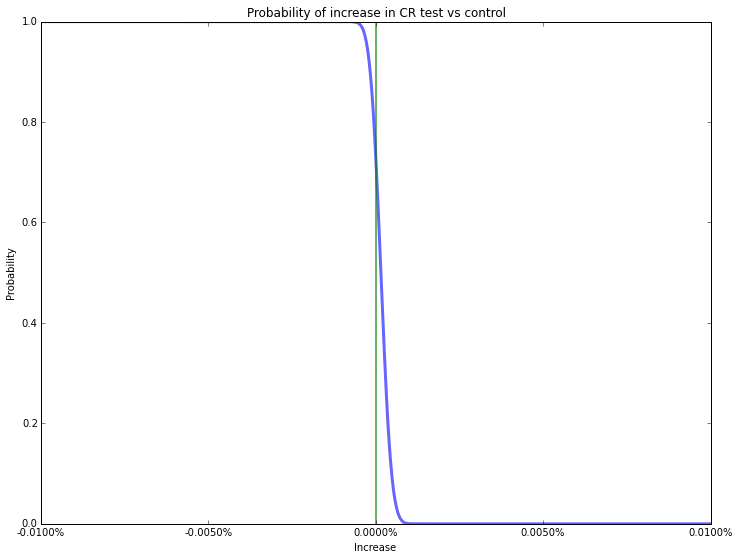

In [15]:
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)

ax.plot(probs[0],probs[1],'', lw=3, alpha=0.6);

fmt = '%0.4f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)


xlim(-0.01,0.01)
plt.title('Probability of increase in CR test vs control')
plt.xlabel('Increase')
plt.ylabel('Probability');
#axvline(x=border,linewidth=2, color='g',alpha=0.6);
#plt.text(border*1.1,confidence,'With probability more than {:.0f}% difference is less than {:.4f}%'.format(confidence*100,border),\
#         fontsize = 'large');

### Save data
save data with probabilities of increase to Excel file

In [11]:
from helpers import *
df1 = pd.DataFrame(probs[0])
df1.columns = ['difference']
df1['probability'] = probs[1]
df1.to_excel('./excel_data/cr.xlsx')
#print upload_to_google_drive(df1,'cr.xlsx')

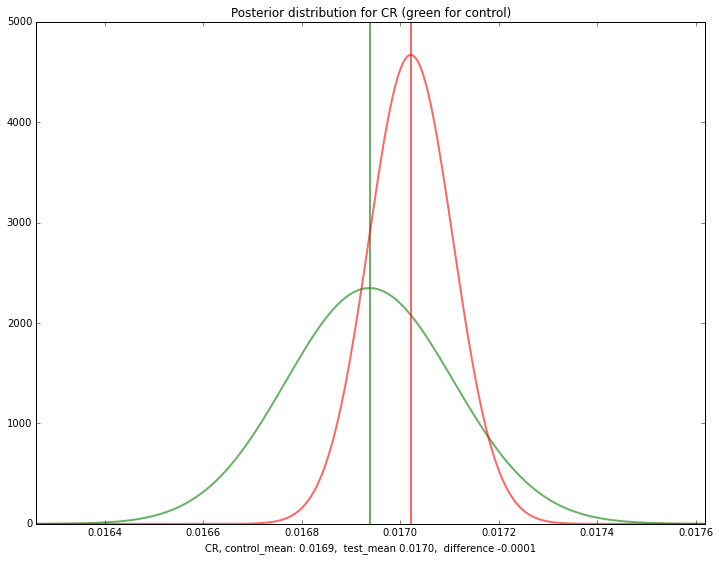

In [12]:
from scipy.stats import beta as beta2

x = np.linspace(0,0.1,20000)

#control group
a_control = orders_a+alpha
b_control = visits_a-orders_a+beta
mean_control, var_control, skew_control, kurt_control = beta2.stats(a_control, b_control, moments='mvsk')
pdf_a = beta2.pdf(x, a_control, b_control,loc=0, scale=1)

#test group
a_test = (orders_b+alpha)
b_test = visits_b-orders_b+beta
pdf_b = beta2.pdf(x, a_test, b_test,loc=0, scale=1)
mean_test, var_test, skew_test, kurt_test = beta2.stats(a_test, b_test, moments='mvsk')

plt.plot(x, pdf_a, 'g-', lw=2, alpha=0.6);
axvline(x=mean_control,linewidth=2, color='g',alpha=0.6);

plt.plot(x, pdf_b, 'r-', lw=2, alpha=0.6);
axvline(x=mean_test,linewidth=2, color='r',alpha=0.6);

#border for plot
low_b = min(mean_control - 4*sqrt(var_control), mean_test - 4*sqrt(var_test))
high_b = max(mean_control + 4*sqrt(var_control), mean_test + 4*sqrt(var_test))

#xlim(0.016,0.018);
xlim(low_b,high_b);
plt.xlabel('CR, control_mean: {:.4f},  test_mean {:.4f},  difference {:.4f}'.format(float(mean_control),\
                                                                      float(mean_test),float(mean_control-mean_test)))
#plt.ylabel('net revenue')
plt.title('Posterior distribution for CR (green for control)');

### CTR tests
The result is 2 plots:
1. Probability of increase in test group vs control group
2. Posterior distribution in test group vs control group

In [13]:
N_samp = 100000 # number of samples to draw for MC integration
pp_qv_a = ctr_a_df.pp_qv_from_cat[0] # clicks in control group
cat_shows_a = ctr_a_df.cat_shows[0] # views in control group
pp_qv_b = ctr_b_df.pp_qv_from_cat[0] # clicks in test group
cat_shows_b = ctr_b_df.cat_shows[0] # views in test group
alpha = 1 # noninformative prior
beta = 1
A_samples = beta_dist(pp_qv_a+alpha, cat_shows_a-pp_qv_a+beta, N_samp)
B_samples = beta_dist((pp_qv_b+alpha), cat_shows_b-pp_qv_b+beta, N_samp)
B_A_samples = B_samples - A_samples

#difference in means
probs = np.array([[],[]])
np.mean(B_A_samples > 0)
border = 0
confidence = 0.75
for i in range(-1000,1000):
    d = float(i)/float(50000)
    probs = np.append(probs,[[d],[np.mean(B_A_samples > d)]], axis = 1)
#    if probs[1][i] >= confidence:
#            border = d

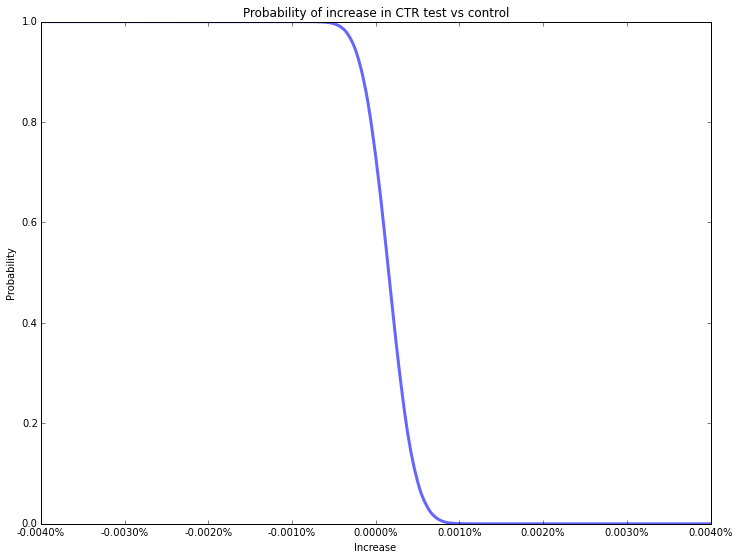

In [16]:
fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)

ax.plot(probs[0],probs[1],'', lw=3, alpha=0.6);

fmt = '%0.4f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)


xlim(-0.004,0.004)
plt.title('Probability of increase in CTR test vs control')
plt.xlabel('Increase')
plt.ylabel('Probability');
#axvline(x=border,linewidth=2, color='g',alpha=0.6);
#plt.text(border*1.1,confidence,'With probability more than {:.0f}% difference is less than {:.4f}%'.format(confidence*100,border),\
#         fontsize = 'large');

### Save data
save data with probabilities of increase to Excel file

In [17]:
df1 = pd.DataFrame(probs[0])
df1.columns = ['difference']
df1['probability'] = probs[1]
df1.to_excel('./excel_data/ctr.xlsx')

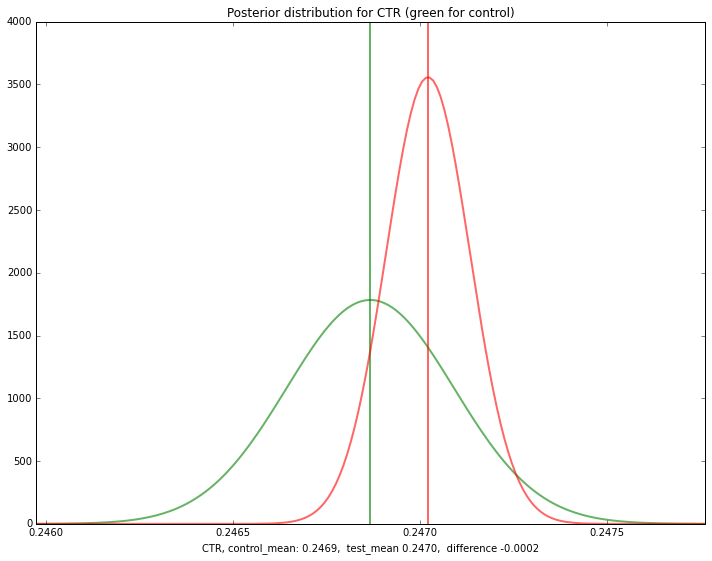

In [18]:
x = np.linspace(0.15,0.35,20000)

#control group
a_control = pp_qv_a+alpha
b_control = cat_shows_a-pp_qv_a+beta
mean_control, var_control, skew_control, kurt_control = beta2.stats(a_control, b_control, moments='mvsk')
pdf_a = beta2.pdf(x, a_control, b_control,loc=0, scale=1)

#test group
a_test = pp_qv_b+alpha
b_test = cat_shows_b-pp_qv_b+beta
pdf_b = beta2.pdf(x, a_test, b_test,loc=0, scale=1)
mean_test, var_test, skew_test, kurt_test = beta2.stats(a_test, b_test, moments='mvsk')

plt.plot(x, pdf_a, 'g-', lw=2, alpha=0.6);
axvline(x=mean_control,linewidth=2, color='g',alpha=0.6);

plt.plot(x, pdf_b, 'r-', lw=2, alpha=0.6);
axvline(x=mean_test,linewidth=2, color='r',alpha=0.6);

#border for plot
low_b = min(mean_control - 4*sqrt(var_control), mean_test - 4*sqrt(var_test))
high_b = max(mean_control + 4*sqrt(var_control), mean_test + 4*sqrt(var_test))

#xlim(0.016,0.018);
xlim(low_b,high_b);
plt.xlabel('CTR, control_mean: {:.4f},  test_mean {:.4f},  difference {:.4f}'.format(float(mean_control),\
                                                                      float(mean_test),float(mean_control-mean_test)))
#plt.ylabel('net revenue')
plt.title('Posterior distribution for CTR (green for control)');